## Swarm A/B conjunction points

This demo notebooks calculates Swarm A/B conjunction points from the MODx_SC_1B (or MAGx_LR_1B) spacecraft positions.


In [1]:
ANGULAR_DISTANCE_THRESHOLD = 1.0 # deg

SERVER_URL = "https://vires.services/ows"

COLLECTION = "SW_OPER_MOD{spacecraft}_SC_1B"
#COLLECTION = "SW_OPER_MAG{spacecraft}_LR_1B"


### VirES data retrieval

The data are retrieved from VirES. The algorith works with 1 second spacecraft positions provided by the `MODx_SC_1B` or `MAGx_LR_1B` datasets.

In [2]:
from viresclient import SwarmRequest

SwarmRequest.COLLECTIONS["MOD_SC"] = [
    "SW_OPER_MOD{}_SC_1B".format(x) for x in "ABC"
]
SwarmRequest.PRODUCT_VARIABLES["MOD_SC"] = []


def get_swarm_orbit(spacecraft, start_time, end_time, asynchronous=False, **opts):
    "Retrieve Swarm-A/B locations for the given time-interval from the VirES server."
    print(f"Retrieving Swarm {spacecraft} orbit from {start_time} to {end_time} ... ")
    request = SwarmRequest(SERVER_URL)
    request.set_collection(COLLECTION.format(spacecraft=spacecraft))
    request.set_products(measurements=[], **opts)
    return request.get_between(
        start_time=start_time,
        end_time=end_time,
        asynchronous=asynchronous,
    ).as_xarray()


def get_swarm_ab_orbits(start_time, end_time, asynchronous=False, **opts):
    "Retrieve Swarm-A/B locations for the given time-interval from the VirES server."
    return (
        get_swarm_orbit("A", start_time, end_time, asynchronous=asynchronous, **opts),
        get_swarm_orbit("B", start_time, end_time, asynchronous=asynchronous, **opts),
    )

The source data may contain gaps which generally differ for each the Swarm spacecraft. It is therefore necessary to bring the source data to the same time-line.

The follwing subroutines extract overlaping  Swarm A and Swarm B orbits.

It is assumed the source data are sampled at 1 second. 

In [3]:
from collections import namedtuple
from numpy import timedelta64, searchsorted
from numpy.testing import assert_equal


ONE_SEC = timedelta64(1, 's')
HALF_SEC = timedelta64(500, 'ms')


class TimeRange(namedtuple('TimeRange', ['start', 'end'])):
    """ Time range auxiliary class. """
    
    @property
    def is_empty(self):
        return self.start >= self.end
    
    def trim_start(self, new_start):
        return TimeRange(new_start, self.end)


def extract_overlapping_data(data_a, data_b):
    """ Extract overlaping uninterupted data segments. """
    timestamp_a, position_a = extract_orbit(data_a)
    timestamp_b, position_b = extract_orbit(data_b)
    
    time_ranges_a = generate_time_ranges(timestamp_a)
    time_ranges_b = generate_time_ranges(timestamp_b)
    
    for time_range in generate_time_range_overlaps(time_ranges_a, time_ranges_b):
        slice_a = get_temporal_slice(timestamp_a, *time_range)
        slice_b = get_temporal_slice(timestamp_b, *time_range)
        assert_equal(timestamp_a[slice_a], timestamp_b[slice_b])
        yield timestamp_a[slice_a], position_a[slice_a], position_b[slice_b]
        

def get_temporal_slice(timestamps, start_time, end_time):
    """ Get Pyhton slice object selecting sorted timestamps within the given time range. """
    start, end = searchsorted(timestamps, (start_time, end_time), side='left')
    return slice(start, end)


def generate_time_ranges(timestamp):
    """ Get time ranges of continuous data segments assuming 1s data sampling. """    
    timestamp = round_time_to_seconds(timestamp)
    if timestamp.size == 0:
        return
    dt = timestamp[1:] - timestamp[:-1]
    assert dt.size == 0 or dt.min() >= ONE_SEC
    idx_start = 0
    for idx_end in (dt > ONE_SEC).nonzero()[0]:
        yield TimeRange(timestamp[idx_start], timestamp[idx_end] + ONE_SEC)
        idx_start = idx_end + 1
    yield TimeRange(timestamp[idx_start], timestamp[-1] + ONE_SEC)

    
def generate_time_range_overlaps(ranges_a, ranges_b):
    """ Generage overlaping time ranges. """
    
    def _get_next_range(range_iterator):
        for range_ in range_iterator:
            if not range_.is_empty:
                return range_
        return None

    range_a = _get_next_range(ranges_a)
    range_b = _get_next_range(ranges_b)
    
    while range_a and range_b:

        if range_a.start < range_b.start:
            range_a = range_a.trim_start(range_b.start)
        elif range_b.start < range_a.start:
            range_a = range_a.trim_start(range_b.start)
        else: # range_a.start == range_b.start
            overlap = TimeRange(range_a.start, min(range_a.end, range_b.end))
            yield overlap
            range_a = range_a.trim_start(overlap.end)
            range_b = range_b.trim_start(overlap.end)

        if range_a.is_empty:
            range_a = _get_next_range(ranges_a)
        if range_b.is_empty:
            range_b = _get_next_range(ranges_b)

        
def extract_orbit(data):
    """ Extract spacecraft times and position in geocentric sperical coordinates from the VirES response. """
    timestamp = data['Timestamp'].values
    position = stack((
        data['Latitude'].values,
        data['Longitude'].values,
        data['Radius'].values
    ), axis=-1)
    return timestamp, position


def round_time_to_seconds(timestamp):
    """Round times to whole seconds."""
    return (timestamp + HALF_SEC).astype('datetime64[s]') 


### Conjunction points calculation

The conjunction points are calculated as the times of the local minima in the *angular distance* between the spacecrafts. Only spacecraft approaches below the configured threshold are accepted.

The *angular distance* is defined as the angle $\theta$ between the Swarm A and B spacecraft's Cartesian positions $\vec{a}$ and $\vec{b}$ in the geocentric frame.
$$ \cos(\theta) = \frac{\vec{a}\cdot \vec{b}}{\|\vec{a}\| \ \|\vec{b}\|} = \vec{a_n}\cdot\vec{b_n} $$

The normalized Cartesian positions $\vec{x_n}$ are obtained from the geocentric sperical coordinates $(\phi, \lambda, r)$ obtained from the data with the radius set to $1$.

$$ \vec{x_n} = \frac{ \vec{x} }{\|\vec{x}\|} = F_{\text{Sph2Cart}}(\phi, \lambda, 1)$$

Where $F_{\text{Sph2Cart}}$ converts spherical to Cartesian coordinates.

$$\vec{x} = (x, y, x) = F_{\text{Sph2Cart}}(\phi, \lambda, r)$$

The *angular distance* $\theta$ is then evalued from the dot product of the Swarm A and B spacecraft's  normalized Cartesian positions $\vec{a_n}$ and $\vec{b_n}$

$$ \theta = \arccos\left(\vec{a_n}\cdot\vec{b_n}\right) $$


In [4]:
from numpy import degrees, stack, ones, arccos
from eoxmagmod import convert, GEOCENTRIC_CARTESIAN, GEOCENTRIC_SPHERICAL

def get_angular_distance(latlon1, latlon2):
    """ Calculate angular distance in degrees from two spherical (latitude, longitude) coordinates in degrees. """
    xyz1 = convert(
        stack((latlon1[..., 0], latlon1[..., 1], ones(latlon1.shape[:-1])), axis=-1),
        GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN
    )    
    xyz2 = convert(
        stack((latlon2[..., 0], latlon2[..., 1], ones(latlon2.shape[:-1])), axis=-1),
        GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN
    )
    return degrees(arccos((xyz1 * xyz2).sum(axis=-1)))


/opt/conda/lib/python3.8/site-packages/spacepy/time.py:2294: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


The local minima in the angualar distance between the spacecrafts are found with the following subroutine.

In [5]:
from numpy import arange, sign

def get_local_minima(values):
    """ Find indices of the local minima of the given series. """
      
    def _find_min_ranges():
        slope_sign = sign(values[2:] - values[:-2])
        for idx0 in (slope_sign[:-1] < slope_sign[1:]).nonzero()[0]:
            if slope_sign[idx0] != -1:
                continue
            for idx1 in range(idx0 +1, len(slope_sign)):
                if slope_sign[idx1] != +1:
                    continue
                break
            else:
                break
            yield (idx0+1, idx1+2)
    
    def _find_min():
        index = arange(len(values))
        for idx0, idx1 in _find_min_ranges():
            yield index[idx0:idx1][values[idx0:idx1].argmin()]

    return list(_find_min())


def calculate_slope(times, values):
    " Calculate slopes per interval, equidistant sampling is assumed."
    return times[1:-1], 0.5*(values[2:] - values[:-2])


This code puts all the bits together and calculates the conjunction points.

In [6]:
from numpy import zeros, concatenate

def calculate_swarm_ab_conjunctions(data_a, data_b, threshold=ANGULAR_DISTANCE_THRESHOLD):
    
    timestamp_cj, position_a_cj, position_b_cj, angular_distance_cj = [], [], [], []
    # extract overlapping data segments
    for timestamp, position_a, position_b in extract_overlapping_data(data_a, data_b):
        angular_distance = get_angular_distance(position_a, position_b)
        idx_min = get_local_minima(angular_distance)

        selection_mask = zeros(timestamp.shape, dtype='bool')
        selection_mask[idx_min] = True # select minima
        selection_mask[angular_distance > threshold] = False # filter out data above threshold
        
        timestamp_cj.append(round_time_to_seconds(timestamp[selection_mask]))
        position_a_cj.append(position_a[selection_mask])
        position_b_cj.append(position_b[selection_mask])
        angular_distance_cj.append(angular_distance[selection_mask])
        
    return {
        "Timestamp": concatenate(timestamp_cj),
        "PositionA": concatenate(position_a_cj),
        "PositionB": concatenate(position_b_cj),
        "AngularDistance": concatenate(angular_distance_cj),
    }

### Visual presentation of the conjunction points

HTML table ...

In [7]:
from IPython.display import HTML, display

def dump_swarm_ab_conjunctions(conjunctions):
    def _get_data():
        yield ('Conjunction time', 'Angular distance / deg', 'Swarm A position', 'Swarm B position')
        for time, pos_a, pos_b, adist in zip(*conjunctions.values()):
            yield (
                f"{time}",
                f"{adist:.1f}",
                f"{pos_a[0]:.1f}, {pos_a[1]:.1f}",
                f"{pos_b[0]:.1f}, {pos_b[1]:.1f}"
            )

    def _tabulate(lines):
        yield "<table>"
        yield "<tr>%s</tr>" % "".join(f'<th style="text-align:center;">{field}</th>' for field in next(lines))
        for record in lines:
            yield "<tr>%s</tr>" % "".join(f'<td style="text-align:center;">{field}</td>' for field in record)
        yield "</table>"

    return display(HTML("\n".join(_tabulate(_get_data()))))


Angular distance plot ...

In [8]:
from matplotlib.pyplot import figure, subplot, show


def plot_swarm_ab_conjunction_points(data_a, data_b, threshold=ANGULAR_DISTANCE_THRESHOLD):   
    fig = figure(figsize=(12, 6), dpi=150)
    ax = subplot(1, 1, 1)
    ax.set_ylim(0, 25)
    ax.set_ylabel('angular distance / deg')
    ax.grid()

    # plot all angular distances
    for timestamp, position_a, position_b in extract_overlapping_data(data_a, data_b):
        angular_distance = get_angular_distance(position_a, position_b)
        h_00, = ax.plot(timestamp, angular_distance, '-', ms=0.1, color='tab:gray')
    
    # plot local minima of angular distances
    minima = calculate_swarm_ab_conjunctions(data_a, data_b, threshold=180)
    h_01, = ax.plot(minima['Timestamp'], minima['AngularDistance'], '.', color='tab:blue')
    
    # plot threshold line
    time_min = min(data_a['Timestamp'].values[0], data_b['Timestamp'].values[0])
    time_max = max(data_a['Timestamp'].values[-1], data_b['Timestamp'].values[-1])
    h_02, = ax.plot([time_min, time_max], [ANGULAR_DISTANCE_THRESHOLD, ANGULAR_DISTANCE_THRESHOLD], '-', color='tab:red')
    
    # plot the actual conjunctions
    conjunctions = calculate_swarm_ab_conjunctions(data_a, data_b, threshold=ANGULAR_DISTANCE_THRESHOLD)
    h_03, = ax.plot(conjunctions['Timestamp'], conjunctions['AngularDistance'], '.', color='tab:orange')

    ax.legend(
        [h_03, h_01, h_00, h_02], 
        [
            'Conjuction points', 
            'Swarm A/B angular distance - local minima',
            'Swarm A/B angular distance',
            f'Threshold {ANGULAR_DISTANCE_THRESHOLD} deg'
        ],
        loc='upper right',
    )



### Calculation of the conjunction points for the given time interval

Retrieving Swarm A orbit from 2021-07-15T00:00Z to 2021-08-15T00:00Z ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (88.398MB)

Retrieving Swarm B orbit from 2021-07-15T00:00Z to 2021-08-15T00:00Z ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (88.398MB)

Conjunction time,Angular distance / deg,Swarm A position,Swarm B position
2021-07-15T09:13:06,0.9,"-54.0, -87.8","-54.0, -86.3"
2021-07-15T10:00:04,0.7,"52.5, 80.6","52.4, 81.7"
2021-07-15T10:47:03,0.5,"-51.2, -111.0","-51.3, -110.2"
2021-07-15T11:34:01,0.3,"49.7, 57.4","49.7, 57.9"
2021-07-15T12:20:59,0.2,"-48.5, -134.3","-48.5, -134.0"
2021-07-15T13:07:58,0.0,"46.9, 34.1","46.9, 34.1"
2021-07-15T13:54:56,0.2,"-45.7, -157.6","-45.7, -157.8"
2021-07-15T14:41:54,0.4,"44.1, 10.8","44.1, 10.3"
2021-07-15T15:28:52,0.5,"-43.0, 179.1","-42.9, 178.4"
2021-07-15T16:15:51,0.7,"41.3, -12.5","41.3, -13.5"


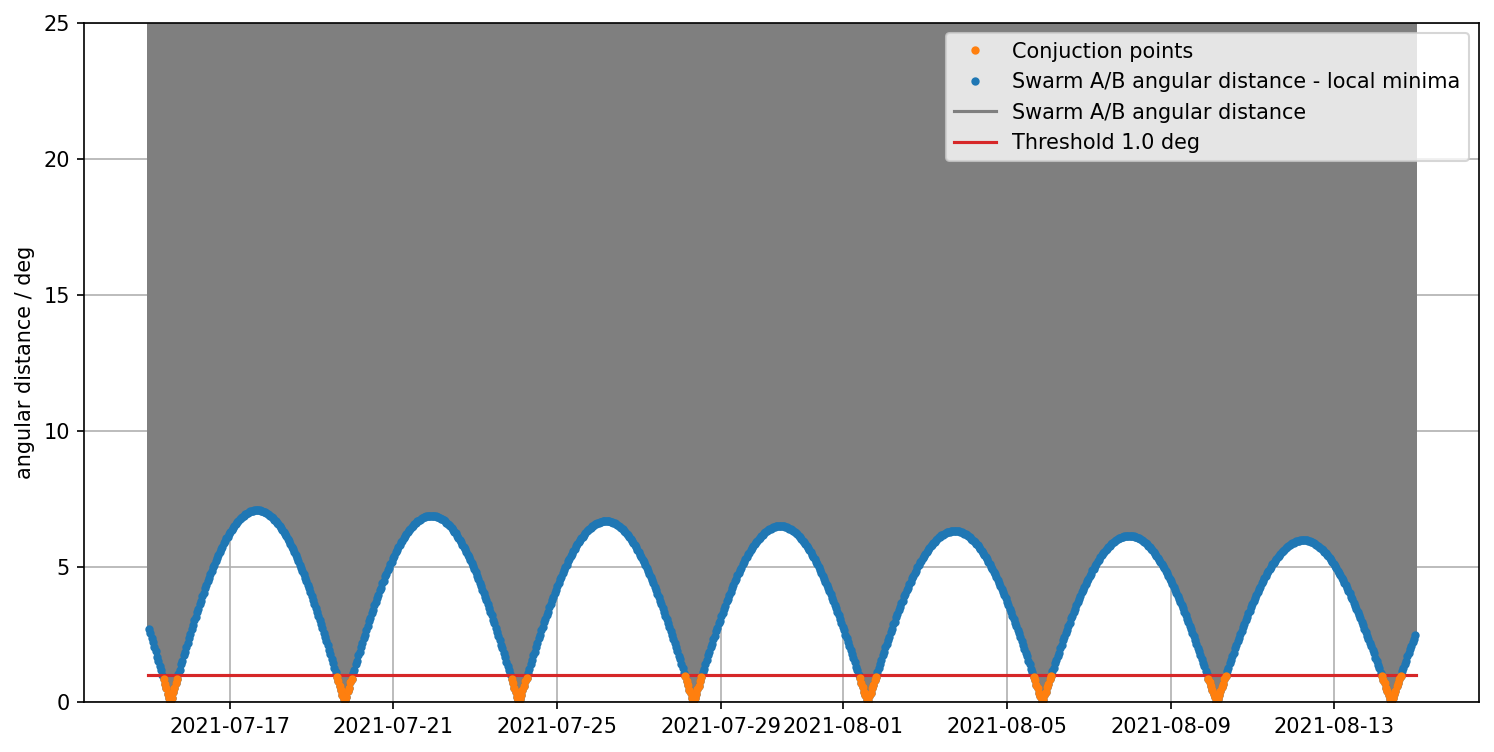

In [9]:
#---------------------------------------------------------------------
# MODA_SC_1B coverage
# 2013-11-25T10:59:54/2020-10-18T23:59:59	SW_OPER_MODA_SC_1B
# 2020-10-19T00:00:00/2020-10-28T23:59:59	<no-data>
# 2020-10-29T00:00:00/2021-08-13T23:59:59	SW_OPER_MODA_SC_1B

# MODB_SC_1B coverage
# 2013-11-25T11:01:15/2014-01-01T23:59:59	SW_OPER_MODB_SC_1B
# 2014-01-02T00:00:00/2014-01-02T08:54:58	<no-data>
# 2014-01-02T08:54:59/2014-01-05T23:59:59	SW_OPER_MODB_SC_1B
# 2014-01-06T00:00:00/2014-01-06T10:34:49	<no-data>
# 2014-01-06T10:34:50/2016-06-22T23:59:59	SW_OPER_MODB_SC_1B
# 2016-06-23T00:00:00/2016-06-23T03:43:08	<no-data>
# 2016-06-23T03:43:09/2020-01-17T23:59:59	SW_OPER_MODB_SC_1B
# 2020-01-18T00:00:00/2020-01-18T10:41:55	<no-data>
# 2020-01-18T10:41:56/2021-08-13T23:59:59	SW_OPER_MODB_SC_1B

#---------------------------------------------------------------------
# MAGA_LR_1B coverage
# 2013-11-25T11:02:52/2014-01-04T10:50:01	SW_OPER_MAGA_LR_1B
# 2014-01-04T10:50:02/2014-01-07T06:50:55	<no-data>
# 2014-01-07T06:50:56/2018-06-01T23:59:59	SW_OPER_MAGA_LR_1B
# 2018-06-02T00:00:00/2018-06-02T23:59:59	<no-data>
# 2018-06-03T00:00:00/2020-10-18T11:48:43	SW_OPER_MAGA_LR_1B
# 2020-10-18T11:48:44/2020-10-28T23:59:59	<no-data>
# 2020-10-29T00:00:00/2021-07-23T23:59:59	SW_OPER_MAGA_LR_1B
# 2021-07-24T00:00:00/2021-07-26T11:32:59	<no-data>
# 2021-07-26T11:33:00/2021-07-31T23:59:59	SW_OPER_MAGA_LR_1B

# MAGA_LR_1B coverage
# 2013-11-25T11:01:15/2013-11-26T15:14:03	SW_OPER_MAGB_LR_1B
# 2013-11-26T15:14:04/2013-11-27T12:59:59	<no-data>
# 2013-11-27T13:00:00/2014-01-01T09:18:04	SW_OPER_MAGB_LR_1B
# 2014-01-01T09:18:05/2014-01-02T11:04:19	<no-data>
# 2014-01-02T11:04:20/2014-01-04T23:59:59	SW_OPER_MAGB_LR_1B
# 2014-01-05T00:00:00/2014-01-07T12:59:59	<no-data>
# 2014-01-07T13:00:00/2015-01-10T23:59:59	SW_OPER_MAGB_LR_1B
# 2015-01-11T00:00:00/2015-01-11T23:59:59	<no-data>
# 2015-01-12T00:00:00/2016-06-22T15:12:58	SW_OPER_MAGB_LR_1B
# 2016-06-22T15:12:59/2016-06-23T12:59:59	<no-data>
# 2016-06-23T13:00:00/2019-08-16T23:59:59	SW_OPER_MAGB_LR_1B
# 2019-08-17T00:00:00/2019-08-17T23:59:59	<no-data>
# 2019-08-18T00:00:00/2020-01-17T13:43:03	SW_OPER_MAGB_LR_1B
# 2020-01-17T13:43:04/2020-01-18T10:41:55	<no-data>
# 2020-01-18T10:41:56/2021-07-31T23:59:59	SW_OPER_MAGB_LR_1B

start_time, end_time = "2021-07-15T00:00Z", "2021-08-15T00:00Z"

data_a, data_b = get_swarm_ab_orbits(start_time, end_time, asynchronous=True, sampling_step='PT1S')

conjunctions = calculate_swarm_ab_conjunctions(data_a, data_b)
dump_swarm_ab_conjunctions(conjunctions)

plot_swarm_ab_conjunction_points(data_a, data_b)

# Close-up of one conjunction point

In [10]:
from cartopy.feature import LAND, OCEAN, COASTLINE
from cartopy.crs import Mollweide, Orthographic, PlateCarree


def iter_conjunctions(data):
    for idx in range(len(data['Timestamp'])):
        yield {
            key: data[key][idx]
            for key in data
        }

def plot_conjunction_map(conjunction):

    def format_latlon(lat, lon):
        return f"{'N' if lat >= 0 else 'S'}{abs(lat):.2f},{'E' if lon >= 0 else 'W'}{abs(lon):.2f}"
    
    def get_subset(data, start_time, end_time):
        times, positions = extract_orbit(data)
        slice_ = get_temporal_slice(times, start_time, end_time)
        return {
            'Timestamp': times[slice_],
            'Position': positions[slice_],
        }

    dt_window = timedelta64(5*60 ,'s')
    dt_1s = timedelta64(1 ,'s')
    orbit_a_before = get_subset(data_a, conjunction['Timestamp'] - dt_window, conjunction['Timestamp'] + dt_1s)
    orbit_b_before = get_subset(data_b, conjunction['Timestamp'] - dt_window, conjunction['Timestamp'] + dt_1s)
    orbit_a_after = get_subset(data_a, conjunction['Timestamp'], conjunction['Timestamp'] + dt_window)
    orbit_b_after = get_subset(data_b, conjunction['Timestamp'], conjunction['Timestamp'] + dt_window)
    
    fig = figure(figsize=(12, 12), dpi=150)
    ax = subplot(1, 1, 1, projection=Orthographic(conjunction['PositionA'][1], conjunction['PositionA'][0]))
    gl = ax.gridlines(crs=PlateCarree(), draw_labels=False, linewidth=1, color='silver', alpha=0.5, linestyle='--')
    
    ax.set_title(
        f"Swarm A/B conjunction @ {conjunction['Timestamp']}Z"
        f" ({format_latlon(conjunction['PositionA'][0], conjunction['PositionA'][1])})"
        f" Δ {conjunction['AngularDistance']:.2f}deg"
    )
    
    ext = 6378073.21863
    ax.set_xlim([-ext, +ext])
    ax.set_ylim([-ext, +ext])
    
    
    ax.add_feature(LAND, facecolor=(1.0, 1.0, 0.9))
    ax.add_feature(OCEAN, facecolor=(0.9, 1.0, 1.0))
    ax.add_feature(COASTLINE, edgecolor='silver')

    ax.plot(orbit_a_after['Position'][:,1], orbit_a_after['Position'][:,0], ':', color='tab:blue', transform=PlateCarree())
    ax.plot(orbit_b_after['Position'][:,1], orbit_b_after['Position'][:,0], ':', color='tab:orange', transform=PlateCarree())
   
    ha, = ax.plot(orbit_a_before['Position'][:,1], orbit_a_before['Position'][:,0], '-', color='tab:blue', transform=PlateCarree())
    hb, = ax.plot(orbit_b_before['Position'][:,1], orbit_b_before['Position'][:,0], '-', color='tab:orange', transform=PlateCarree())
    
    ax.plot(conjunction['PositionA'][1], conjunction['PositionA'][0], '.', color='tab:blue', transform=PlateCarree())
    ax.plot(conjunction['PositionB'][1], conjunction['PositionB'][0], 'o', color='tab:orange', mfc='none', transform=PlateCarree())
    ax.legend([ha, hb],['Swarm A', 'Swarm B'])


Retrieving Swarm A orbit from 2021-08-01T14:29:53Z to 2021-08-01T14:37:53Z ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.045MB)

Retrieving Swarm B orbit from 2021-08-01T14:29:53Z to 2021-08-01T14:37:53Z ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.045MB)

Conjunction time,Angular distance / deg,Swarm A position,Swarm B position
2021-08-01T14:33:53,0.0,"-39.9, 170.2","-39.9, 170.1"


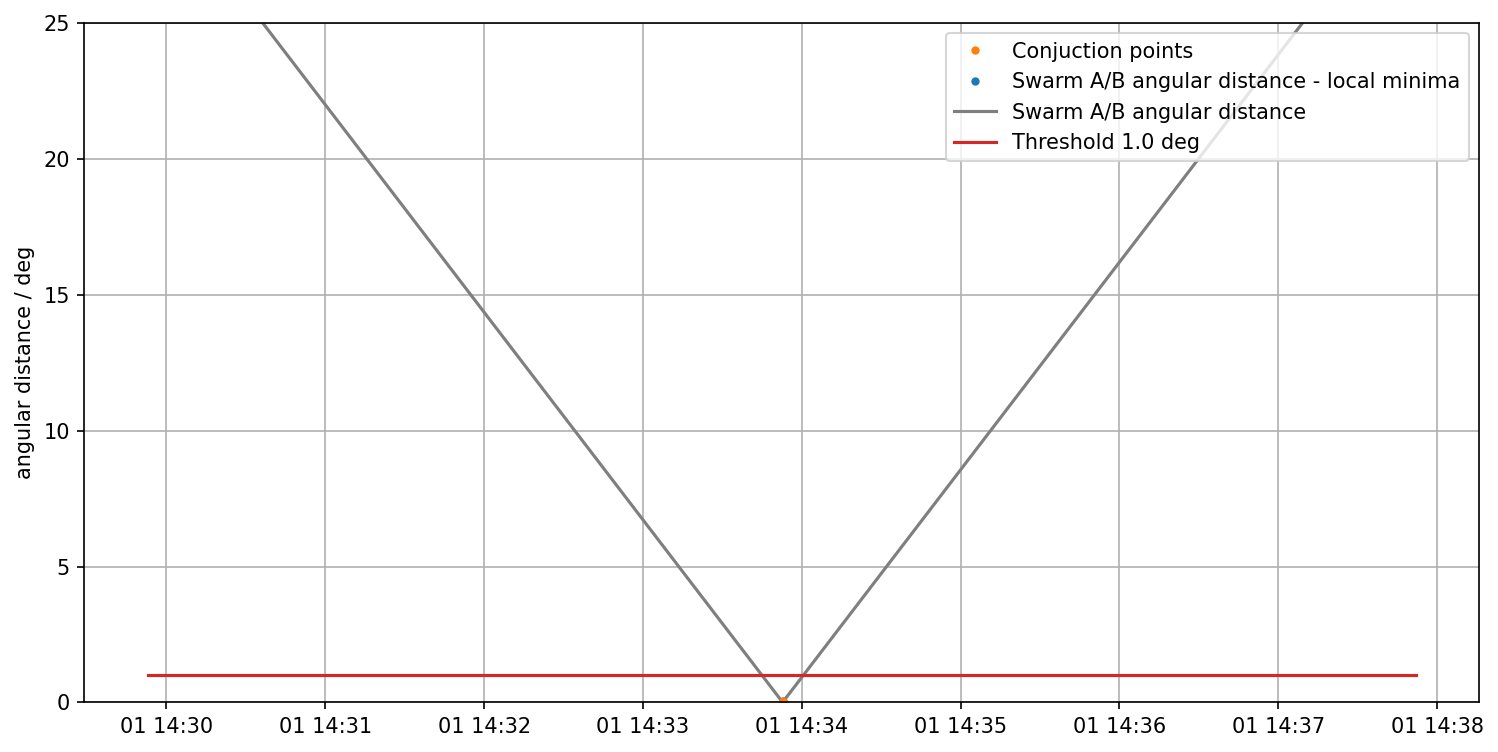

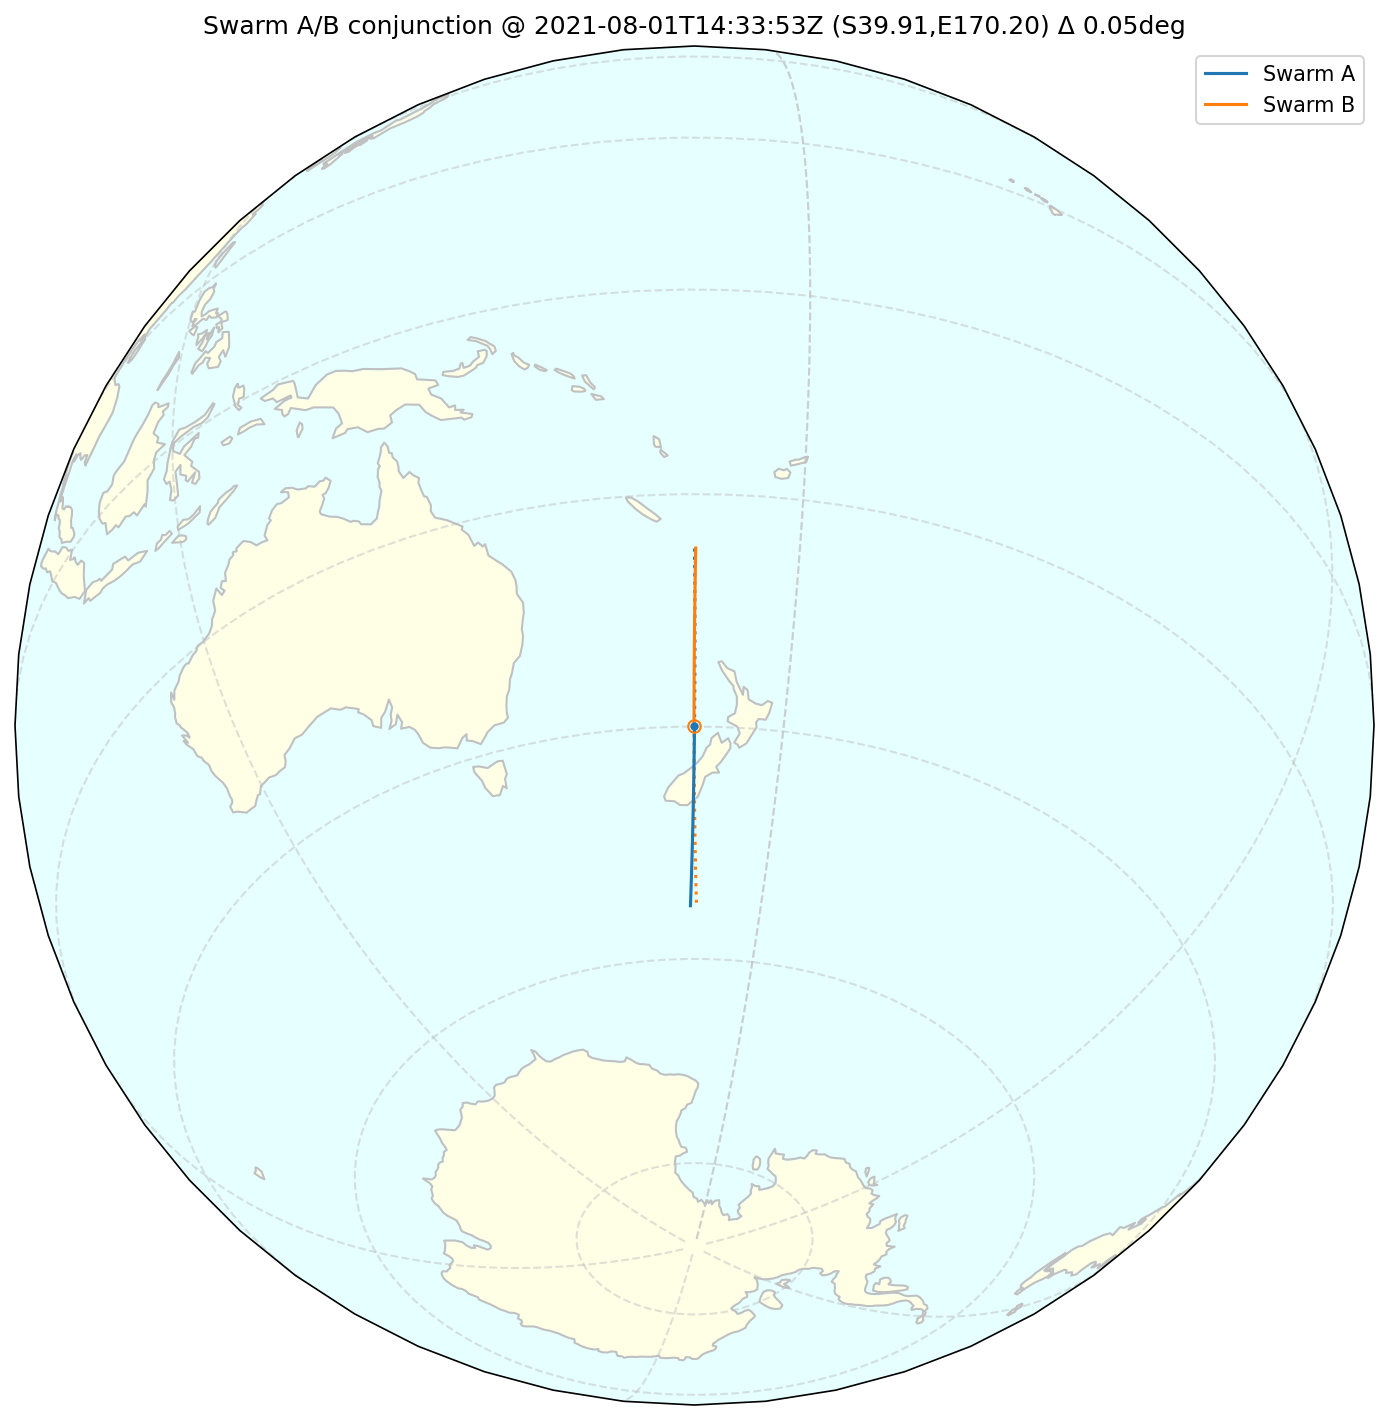

In [11]:
start_time, end_time = "2021-08-01T14:29:53Z", "2021-08-01T14:37:53Z"

data_a, data_b = get_swarm_ab_orbits(start_time, end_time, asynchronous=True, sampling_step='PT1S')

conjunctions = calculate_swarm_ab_conjunctions(data_a, data_b)
dump_swarm_ab_conjunctions(conjunctions)

plot_swarm_ab_conjunction_points(data_a, data_b)
for conjunction in iter_conjunctions(conjunctions):
    plot_conjunction_map(conjunction)

Retrieving Swarm A orbit from 2021-08-10T07:30:56Z to 2021-08-10T07:38:56Z ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.045MB)

Retrieving Swarm B orbit from 2021-08-10T07:30:56Z to 2021-08-10T07:38:56Z ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.045MB)

Conjunction time,Angular distance / deg,Swarm A position,Swarm B position
2021-08-10T07:34:56,0.9,"27.9, 84.0","27.9, 83.0"


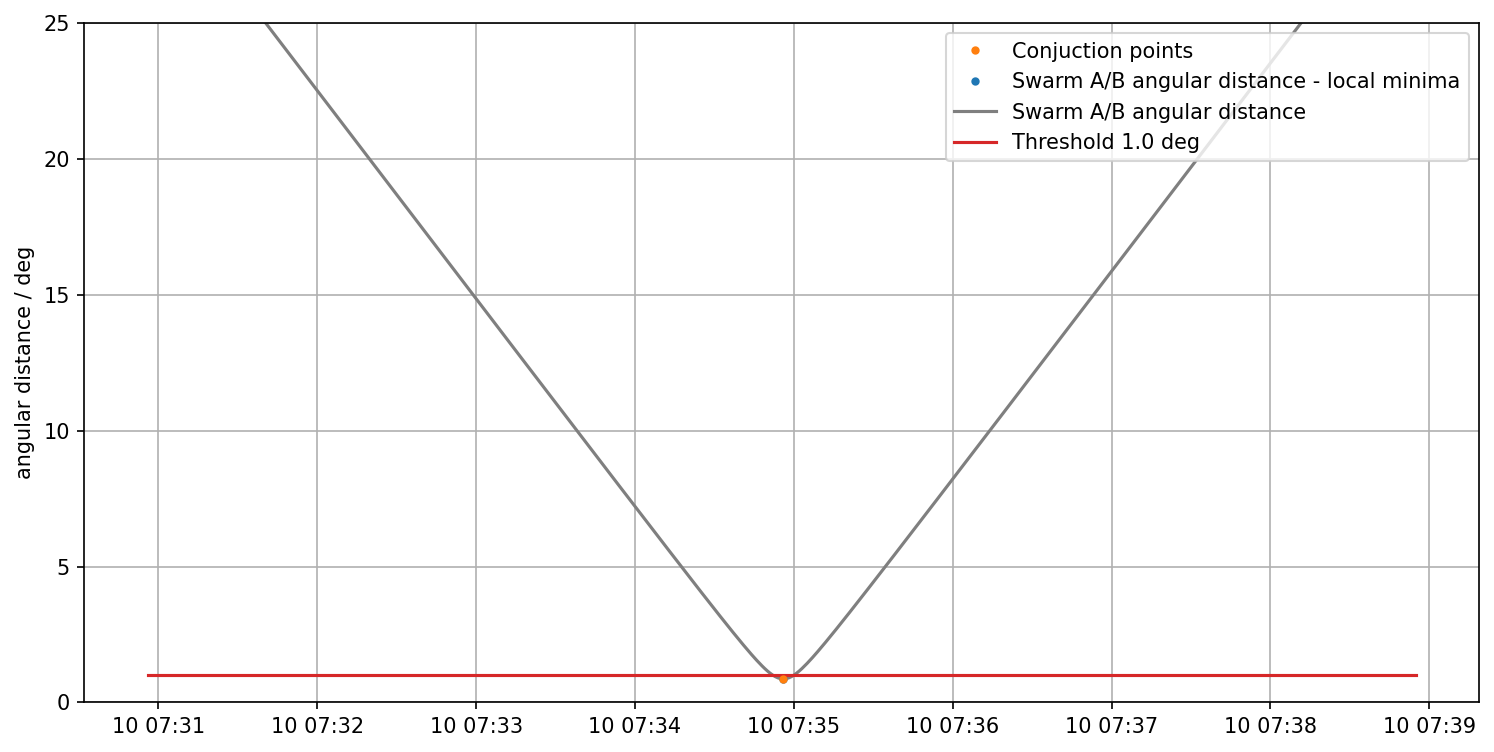

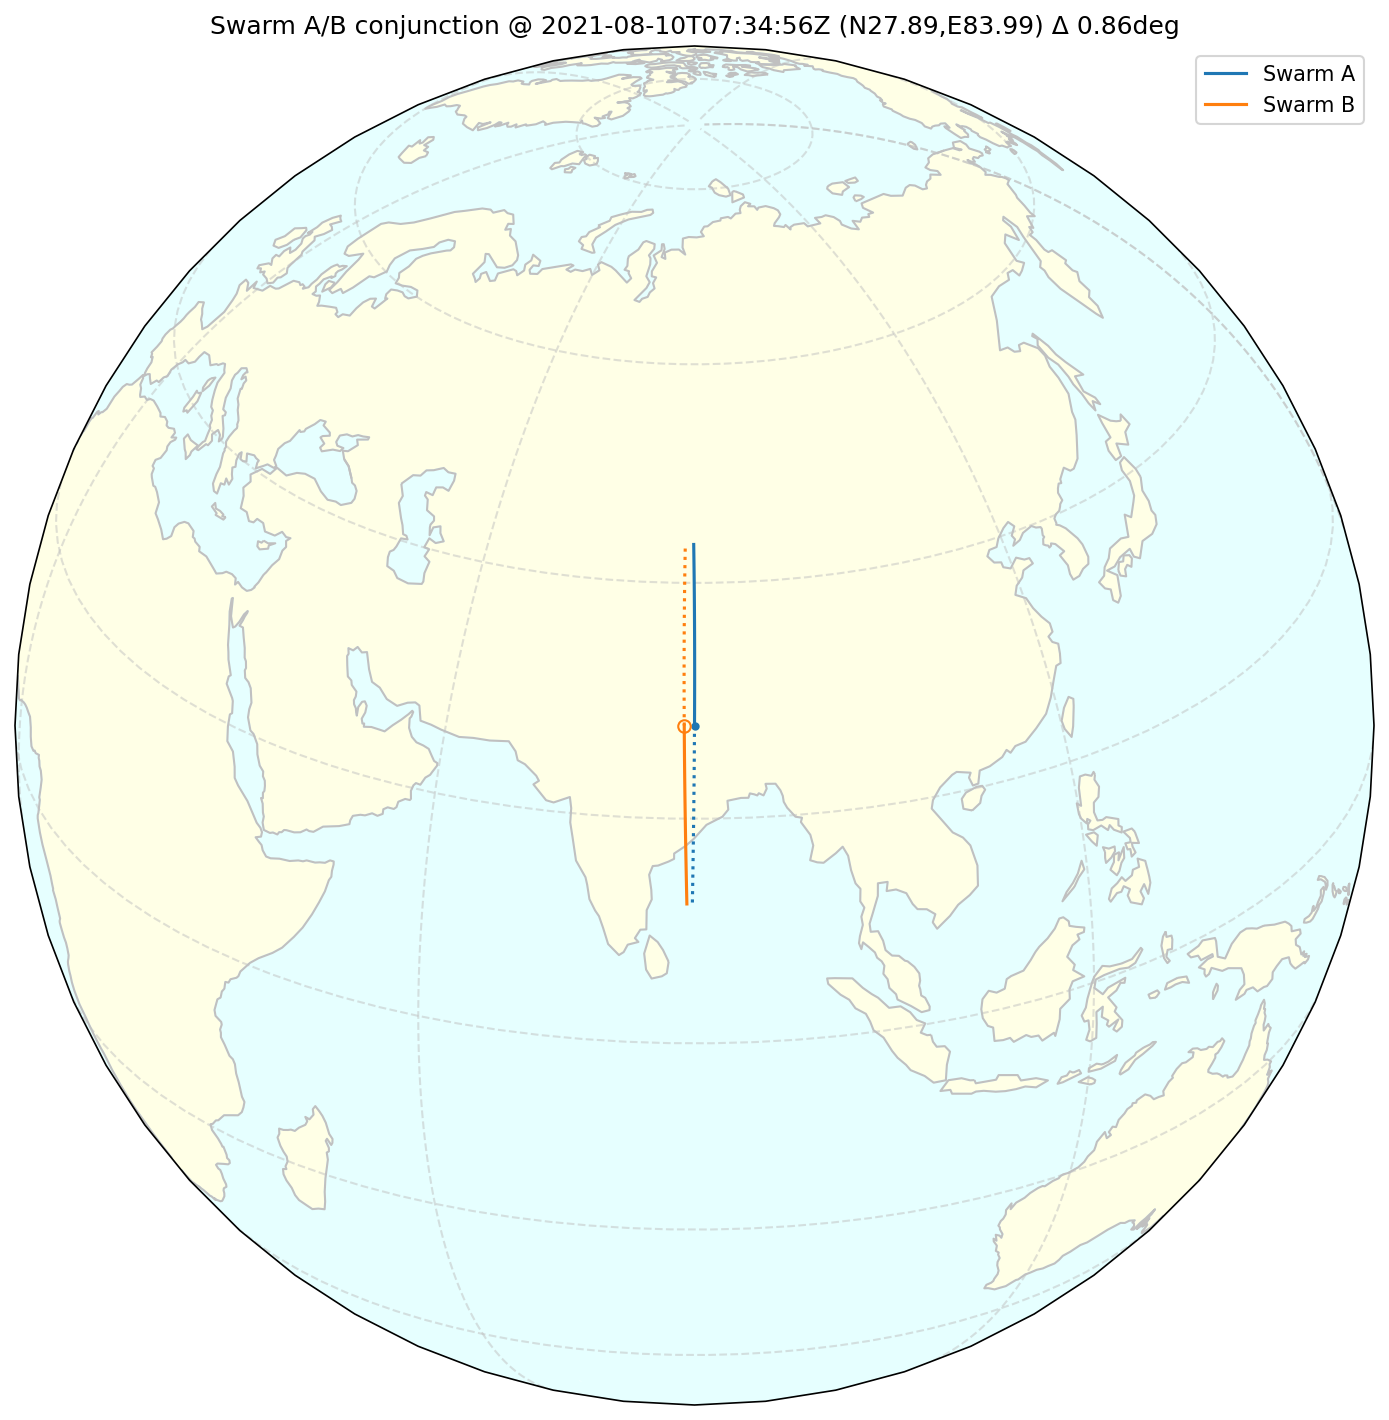

In [12]:
start_time, end_time = "2021-08-10T07:30:56Z", "2021-08-10T07:38:56Z"

data_a, data_b = get_swarm_ab_orbits(start_time, end_time, asynchronous=True, sampling_step='PT1S')

conjunctions = calculate_swarm_ab_conjunctions(data_a, data_b)
dump_swarm_ab_conjunctions(conjunctions)

plot_swarm_ab_conjunction_points(data_a, data_b)
for conjunction in iter_conjunctions(conjunctions):
    plot_conjunction_map(conjunction)